In [1]:
# Basic set-up
p = 3       # Choose the prime p to calculate with
f = 1       # The degree of the residual field extension
e = 2       # The ramification index
q = p^f

# Define the p-adic field and its ring of integers
# L.<Pi> = NumberField(x^2 - p)
# o_L = L.ring_of_integers()
# v = L.valuation(p)
L.<Pi> = Qp(p, prec=1000).ext(x^2 - p)
o_L = L.integer_ring()
v = L.valuation()


# Do linear algebra over the ring of polynomials L[X] in one variable X with coefficients in the field L:
L_X.<X> = L[]
L_Y.<Y> = L[]

from time import process_time

# Decorator to record execution time
def time_this(func, name=None):
    if name is None:
        name = func.__name__
    
    
    def wrap(*args, **kwargs):
        _start = process_time()
        result = func(*args, **kwargs)
        _end   = process_time()
        
        print(f"{_end-_start : .2f} sec: {name}")
        return result

    return wrap

# The subroutine Dmatrix calculates the following sparse matrix of coefficients.
# Let D[k,n] be equal to k! times the coefficient of Y^k in the polynomial P_n(Y). 
# I compute this using the useful and easy recursion formula 
#      D[k,n] = \sum_{r \geq 0} \pi^{-r} D[k-1,n-q^r] 
# that can be derived from Laurent’s Prop 1.20 of "outline9".
# The algorithm is as follows: first make a zero matrix with S rows and columns (roughly, S is (q-1)*Size), 
# then quickly populate it one row at a time, using the recursion formula.

def Dmatrix(S):
    D = matrix(L, S,S)
    D[0,0] = 1
    for k in range(1,S):
        for n in range(k,S):
            r = 0
            while n >= q^r:
                D[k,n] = D[k,n] + D[k-1,n-q^r]/Pi^r  # the actual recursion 
                r = r+1
    return D


# \Tau^{(m)} in Definition 10.10 of "bounded21":
def TauMatrix(Size, m):
    D = Dmatrix((q - 1) * (Size + 1))
    R = matrix(L, Size,Size, lambda x,y: D[m + (q-1)*x, m + (q-1)*y])

    # Define a diagonal matrix:
    Diag = matrix(L_X, Size,Size, lambda x,y: kronecker_delta(x,y) * X^x)

    # Compute the inverse of R:
    S = R.inverse()    

    # Compute the matrix Tau using Lemma 10.11 in "bounded21":
    Tau = S * Diag * R
    
    return Tau

def underscore(m, i):
    return m + i*(q-1)

# Compute the matrix ( \sigma_{ij}(Y) ) using Proposition 10.6 of "bounded21":
def sigmaMatrix(Size):
    sigma = matrix(L_Y, Size,Size)
    
    for m in [0 .. q-2]:
        Tau = TauMatrix(ceil(Size/(q-1)), m)
        j = 0
        while underscore(m, j) < Size:
            i = 0
            while underscore(m, i) < Size:
                sigma[underscore(m, i), underscore(m, j)] = Y^m * Tau[i, j](Y^(q-1))
                i += 1
            j += 1
    
    return sigma

# Construct a vwdwo sequence as per Proposition II.2.3 of Cahen-Chabert:
def vwdwo(N):
    u_ = [i for i in range(q)]  # only for L totally ramified
    
    def u(n):
        return o_L(sum(
            u_[n_i] * Pi^i
            for i, n_i in enumerate(Integer(n).digits(base=q))
        ))
    
    return [u(n) for n in [0 .. N]]

# Compute a regular basis (f_n) as per Theorem II.2.7 of Cahen-Chabert:
def regular_basis(N):
    u = vwdwo(N)
    
    def f(n):
        if n == 0:
            return L_Y(1)
        else:
            return prod((Y - u[k]) / (u[n] - u[k]) for k in [0 .. n-1])
    
    return [f(n) for n in [0 .. N]]


# Find b_i in o_L such that P = \sum b_i f_i:
def regular_basis_coeffs_for(P):
    n = P.degree(Y)
    fs = regular_basis(n)
    u = vwdwo(n)
    bs = [0] * (n + 1)
    for i in [0 .. n]:
        # Since f_i(u_i) = 1; f_j(u_i) = 0 for all j \geq i:
        bs[i] = P(u[i]) - sum(bs[j] * fs[j](u[i]) for j in [0 .. i-1])
    return vector(o_L, bs)

def sigma_coeffs_for_basis(M):
    m = M + 1
    n = (M+2) * (M+1) / 2
    B = Matrix(o_L, m, n)
    
    @time_this
    def compute_sigma():
        return sigmaMatrix(M + 1)
    sigma = compute_sigma()

    @time_this
    def fill_B(B):
        nb_col = 0
        
        for j in [0 .. M]:
            for i in [0 .. j]:
                bs = regular_basis_coeffs_for(sigma[i, j])
                # Only fill in non-zero columns:
                if any(b != 0 for b in bs):                
                    for k, b in enumerate(bs):
                        B[k, nb_col] = b  # Columns of B are the generators
                    nb_col += 1
        
        return B[:, 0:nb_col]
    B = fill_B(B)

    @time_this

    def get_SNF():
        return B.smith_form() 
    A, P, Q = get_SNF()   # A = P B Q

    C = Matrix(L, A[:, 0:M+1])  # A = [C|0]
    
#    return ~P * C  # S_M = o_L . f (~P * A)    
    return ~C * P  # nth column is (\beta_{0,n}, ..., \beta_{M,n})^T
                   # where f_n = \sum_{k=0}^M \beta_{k,n} g_k
                   # and g_0, ..., g_M is a basis for the o_L module

        
def sigma_coeffs_for_basis_iter(M):
    depths = Matrix(QQ, M+1, M+1)  # depths[M, j] = w(M, j), defined below
    depths[0, 0] = 0
    
    sigma = time_this(sigmaMatrix)(M + 1)
    
    with open('w_NumberField.txt', 'w') as file:
        file.write('')
    
    m = 0
    P_0 = Q_0 = B = Matrix(o_L, [[1]])
   
    while m < M:
        m += 1
        print()
        print(m)
        
        @time_this
        def fill_B():
            B_new = Matrix(o_L, m+1, binomial(m+2, 2))
            B_new[:m, :B.ncols()] = B
            nb_col = B.ncols()
            for i in [0 .. m]:
                bs = regular_basis_coeffs_for(sigma[i, m])
                if any(b != Integer(0) for b in bs):
                    B_new[:len(bs), nb_col] = bs
                    nb_col += 1
            B_new = B_new[:, :nb_col]
            return nb_col, B_new
        nb_col, B = fill_B()
        
        P_ = block_matrix([ [P_0, 0], [0, identity_matrix(1)] ])  # GL_{m+1}
        Q_ = block_matrix([ [Q_0, 0], [0, identity_matrix(nb_col - Q_0.nrows())] ])  # GL_{nb_col}
        B_ = Matrix(o_L, P_ * B * Q_)
        
        A, P, Q = time_this(lambda B: B.smith_form(), f"SNF M={m}")(B_)  # A = P B_ Q = P_ P B Q_ Q

        P_0 = P * P_
        Q_0 = Q_ * Q

        # For each M, compute the vector of valuations (w(M,j), j=0..M), where:
        # w(M,j) is the least non-negative rational number such that p^{w(M,j)} . f_j lies in S_M
        Z = ~(A[:, :m+1]) * P_0
        depths[m, :m+1] = vector([
            -min(v(x) for x in Z[:, j].list()) 
            for j in [0 .. m]
        ])
        with open('w_NumberField.txt', 'a') as file:
            file.write(str(depths[m, :m+1].list()) + '\n')
            
        
    
#     return ~(A[:, :m+1]) * P_0 # nth column is (\beta_{0,n}, ..., \beta_{M,n})^T
    return depths


In [2]:
def w_q(n):
    return (n - sum(n.digits(base=q))) / (q-1)


def j_data(N):
    Sigma = sigmaMatrix(N+1)
    
    # Given $j$ and $n$, 
    # does the $o_L$-module generated by $\{ \sigma_{i, j} : 0 \leq i \leq j \}$ 
    # contain a degree-$n$ polynomial satisfying $v_\pi( lead coeff ) = -w_q(n)$ ?
    
    # results[j, n] answers the above question for 0 \leq n \leq j \leq N.
    # We know that the answer is positive when j = 3*q - 2, n = 2*q - 1.
    results = []

    for j in [0 .. N]:
        if j % 25 == 0: print(f"j={j}")
        
        # The rows of A are the coefficients of sigma_{i, j} for 0 \leq i \leq j,
        # i.e., \sigma_{i, j} = \sum_{0 \leq k \leq j} A[i, k] Y^k  (k for kolumn)
        A = Matrix(L, j+1, j+1)
        for i in [0 .. j]:
            sigma_coeffs = Sigma[i, j].list()
            d = Sigma[i,j].degree()
            A[i, :d+1] = vector(sigma_coeffs)

        # Perform Gaussian elimination
        i_top = 0
        ks = []
        for k in reversed([0 .. j]):
            valuation_row_pairs = [ (v(A[i,k]), i) for i in [i_top .. j] if A[i,k] != 0]

            # If we have a zero column, move on to the next one
            if not valuation_row_pairs:
                continue
            minv, i_minv = min(valuation_row_pairs)
            ks.append(k)
            
            # Swap the row of minimum valuation with the top row
            A[i_top, :], A[i_minv, :] = A[i_minv, :], A[i_top, :]
            
            # Divide the top row by a unit in o_L
            a = A[i_top, k]
            mu = a / Pi^int(e * v(a))
            A[i_top, :] /= mu
            
            # Cleave through the other rows
            for i in [i_top+1 .. j]:
                if i != i_top and v(A[i, k]) >= v(A[i_top, k]):
                    A[i, :] -= A[i, k]/A[i_top, k] * A[i_top, :]
        
            i_top += 1
                
        results.append( ["N"]*(j+1) + [""]*(N-j) )
        for i, n in enumerate(ks):
            if e * v(A[i, n]) <= -w_q(n):
                results[-1][n] = "Y"
            else:
                results[-1][n] = e * v(A[i, n]) + w_q(n)
                
    return results

In [3]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

    
def j_graph(results):
    fig = plt.figure(figsize=(20,12), dpi=200)
    ax = fig.add_subplot(111)

    plt.title(r"Does the $o_L$-module generated by $\{\sigma_{i, j} : 0 \leq i \leq j\}$ " \
              r"contain a polynomial of degree $n$ whose leading coefficient has valuation $-w_q(n)$ ?",
              y=-.1)
    
    def cmap(t, n):
        if t == "":
            return [0, 0, 0, 1]
        if t == "Y":
            return [0x1D/256, 0xE4/256, 0xBD/256, 1.]
        if sum(Integer(n).digits(base=q)) <= q-1:
            return [0xEA/256, 0x73/256, 0x69/256, 1.]
        else:
            return [0x82/256, 0x04/256, 0x01/256, 1.]
        
    cells = np.array(
        [ [cmap(t, n) for (n, t) in enumerate(row)] for (j, row) in enumerate(results) ]
    )
    
    plt.imshow(cells, interpolation='nearest')
    plt.xlabel("$n$")
    plt.ylabel("$j$")
    
    plt.show()
    

In [4]:
results = j_data(50)

j=0
j=25
j=50


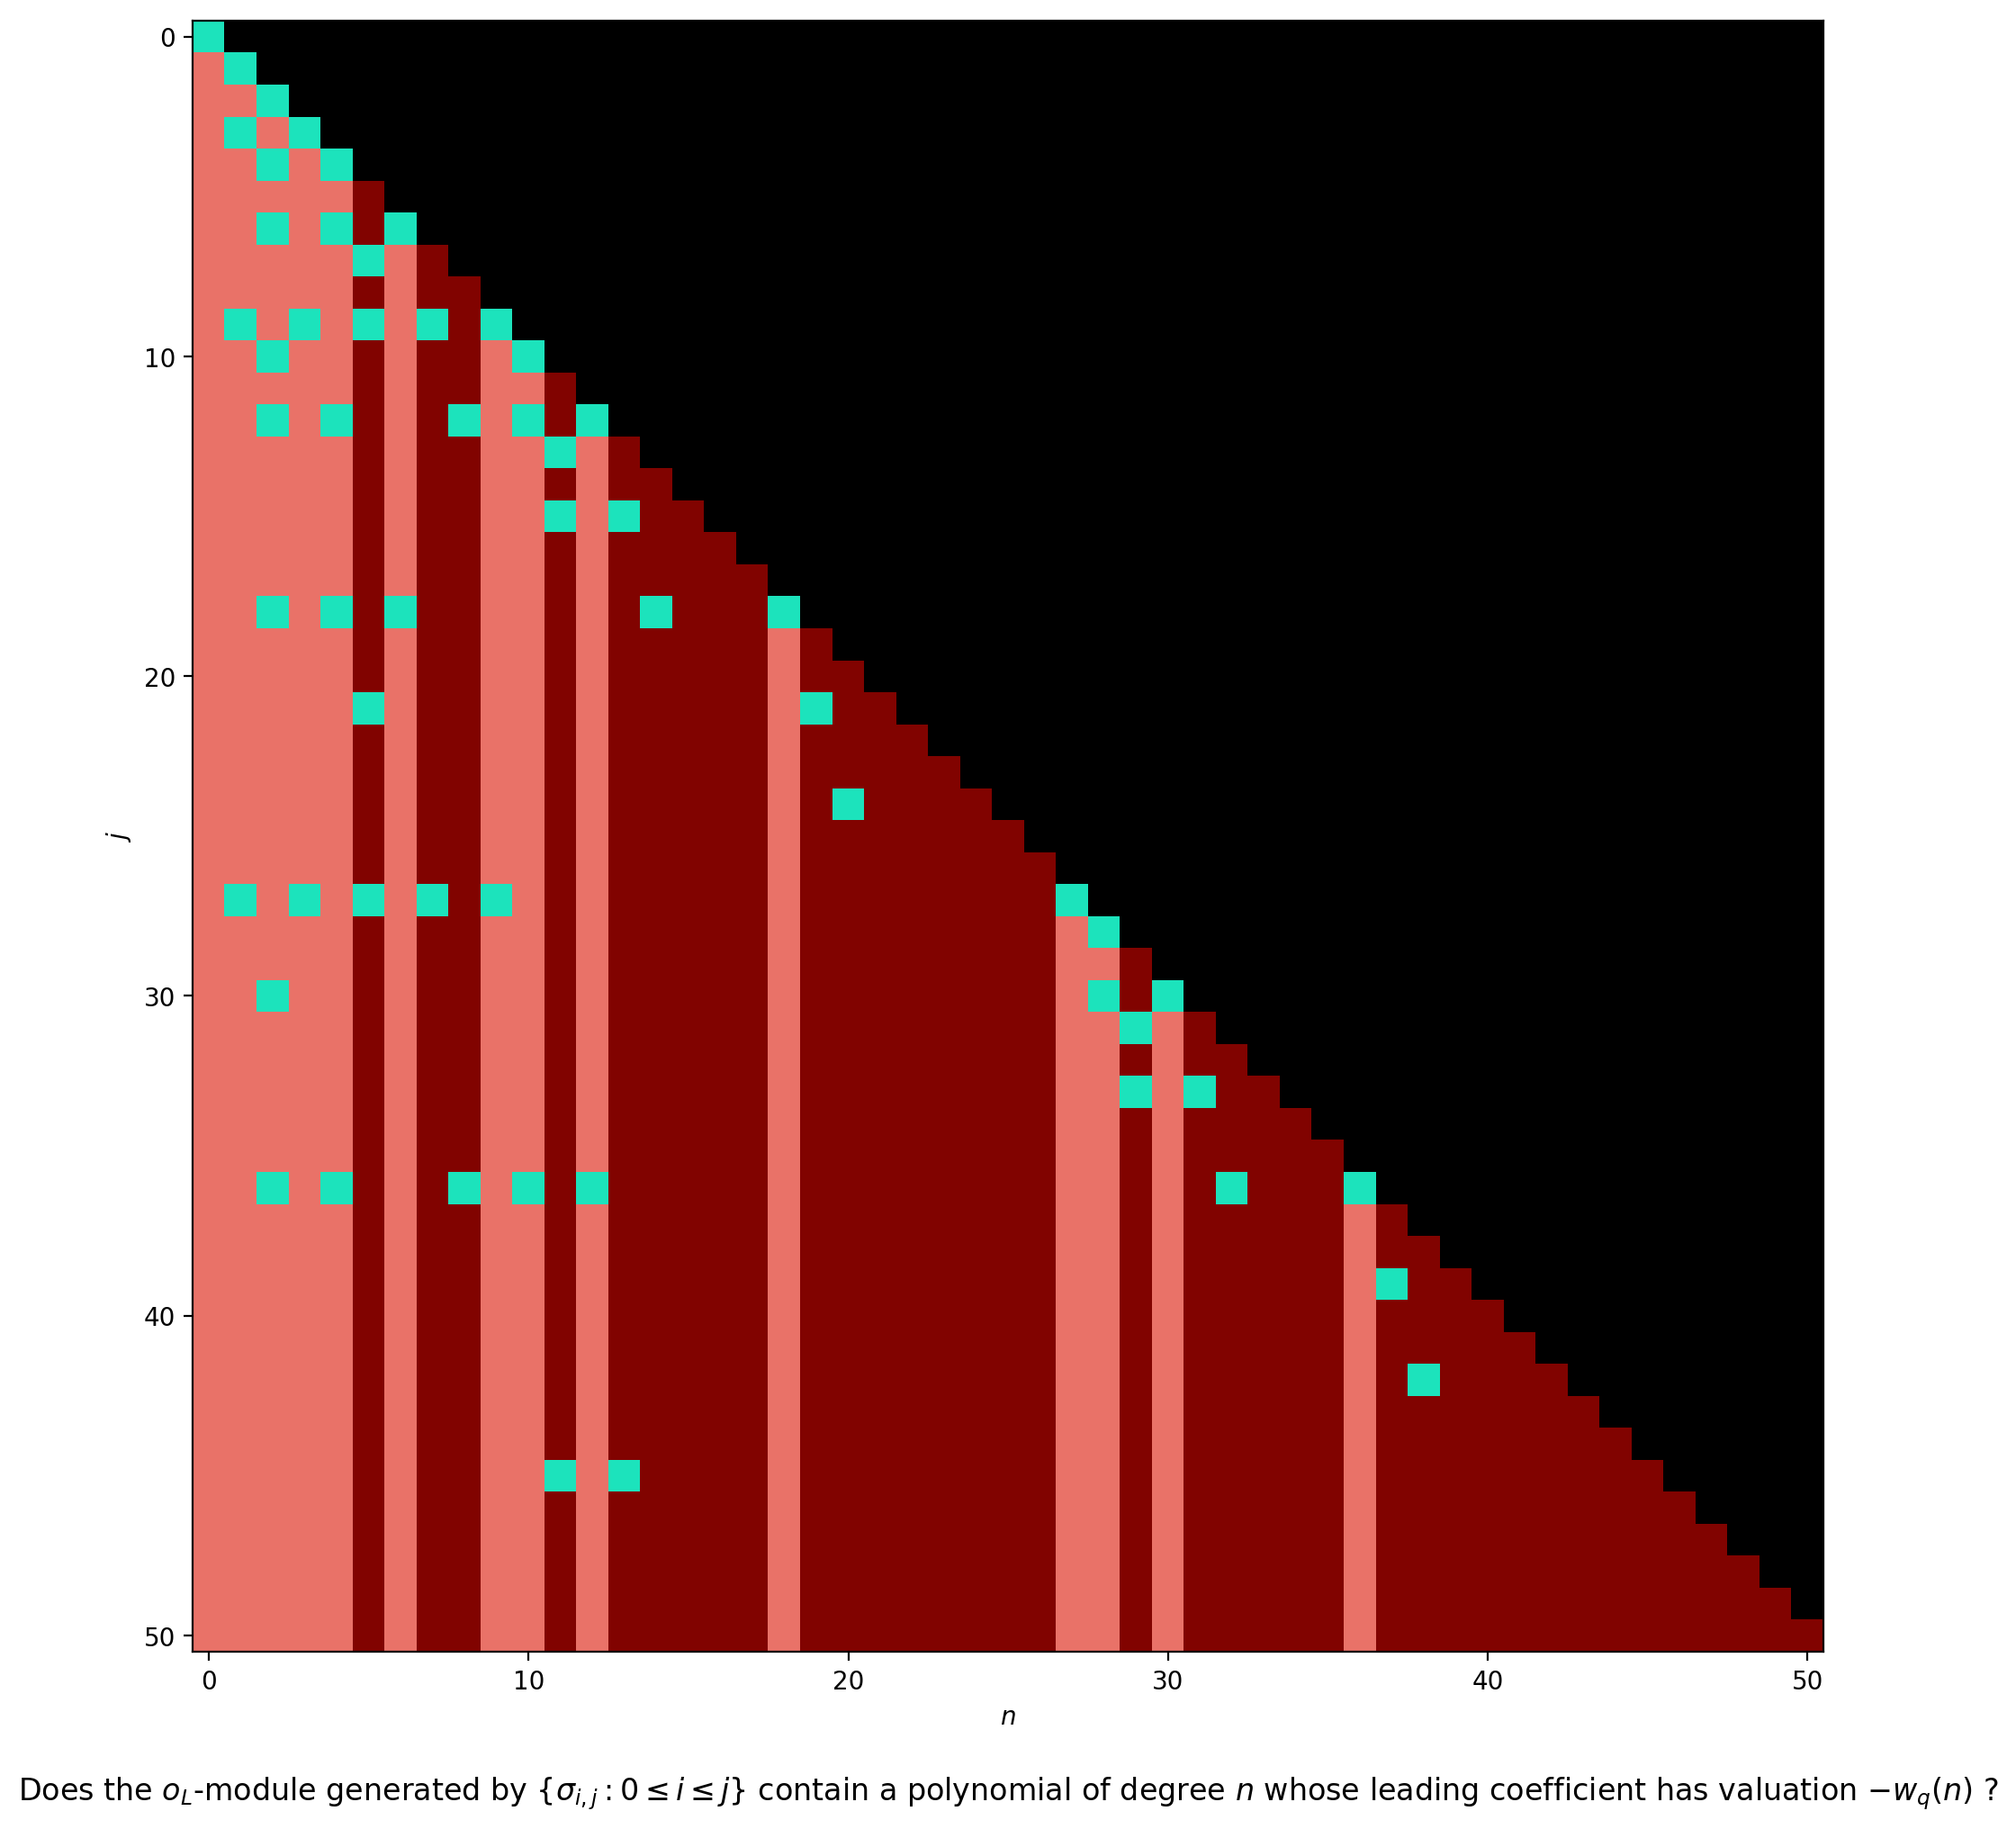

In [5]:
j_graph(results)

In [6]:
def j_new(results, n):
    j_ = 0
    while j_ < len(results) and results[j_][n] != 'Y':
        j_ += 1
    return j_


def s_q(n):
    return sum(Integer(n).digits(base=q))

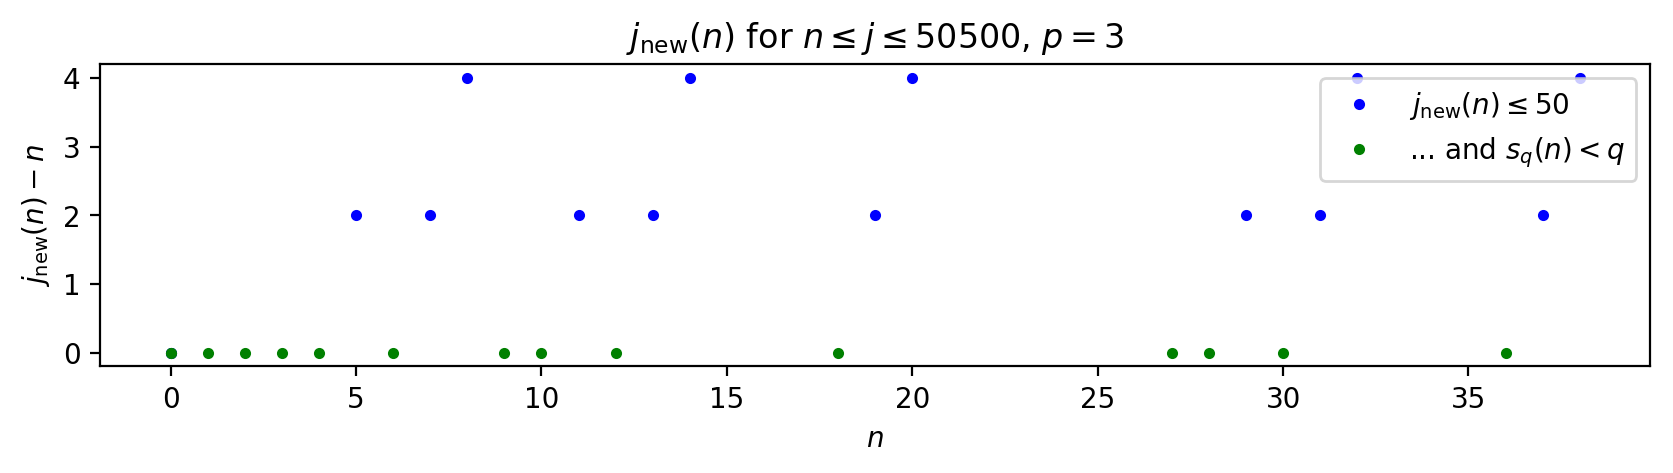

In [7]:
plt.figure(figsize=(10, 2), dpi=200)

for n in range(len(results)):
    j_ = j_new(results, n)
    if j_ < len(results):
        if s_q(n) < q:
            plt.plot(n, j_ - n, 'g.')
        else:
            plt.plot(n, j_ - n, 'b.')
plt.xlabel("$n$")
plt.ylabel(r"$j_{\rm{new}}(n) - n$")
plt.plot(0, 0, 'b.', label=r"$j_{\rm{new}}(n) \leq " + str(len(results) - 1) + "$")
plt.plot(0, 0, 'g.', label="... and $s_q(n) < q$")
plt.legend()
plt.title(r"$j_{\rm{new}}(n)$ for $n \leq j \leq " + str(len(results) - 1) + "500$, $p = 3$")
plt.show()